# Ensemble learning
Tutorial pokrywa najbardziej popularne metody uczenia zespołowego w oparciu o problem klasyfikacji.

Prezentacja dostępna pod linkiem: https://docs.google.com/presentation/d/102wXkjtPx06q1AxpQK76ytD0gamjus-leKIWr7xzjDk/edit?usp=sharing  
Dokumentacja używanych metod: https://scikit-learn.org/stable/modules/ensemble.html

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score

### Używając PCA transformujemy podzbiór MNIST do przestrzeni 30D

In [2]:
mnist = fetch_openml("mnist_784", data_home="data/mnist_784", cache=True)

In [3]:
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)

In [4]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

### Wybieramy ze zbioru dwie trudno rozdzielalne klasy. Będą to zbiory danych do następnych ćwiczeń.

In [5]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)

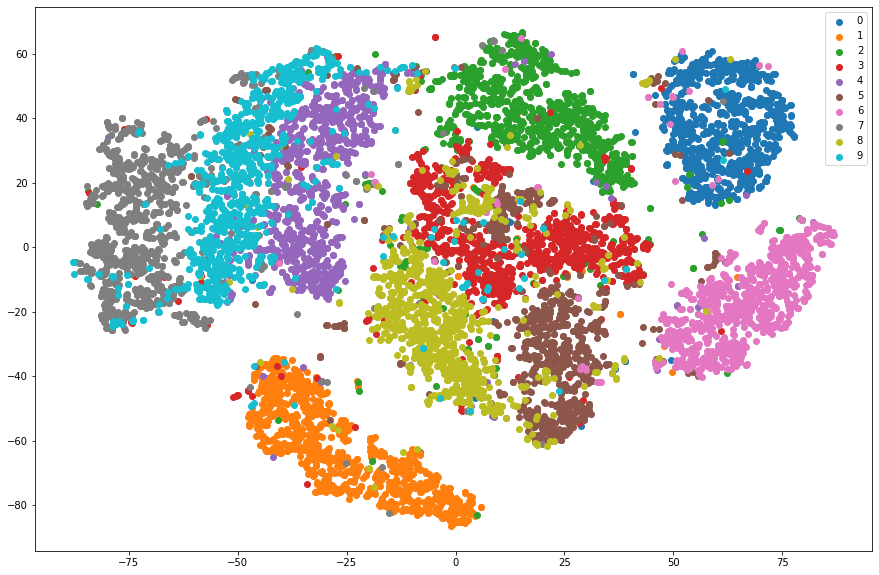

In [6]:
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

Jak widać na powyższym wykresie istnieją klasy, które wzajemnie na siebie nachodzą.  
Przykładem mogą być:  
    - 3 i 8  
    - 3 i 5  
    - 5 i 8  
    - 4 i 9  
    - 7 i 9  
Do dalszych zadań wybieramy klasę 3 i 8 

In [7]:
digit_filter = np.where((y == '3') | (y == '8'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1604, 30)

## Bagging

Każdy z 5 klasyfikatorów jest trenowany za pomocą pozdbioru o wielkości 40% calego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [45]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9675810473815462

Definujemy fukncje pomocnicze do obliczania wyników klasyfikacji oraz ich graficznej prezentacji

In [123]:
def ensemble(Clf, estimators=[5], samples=[0.9], features=[0.9], params={}):
    result = pd.DataFrame(columns=['n_estimators', 'max_features', 'max_samples', 'score_f1', 'score'])
    for n_estimators in estimators:
        for max_samples in samples:
            for max_features in features:
                clf = Clf(max_features=max_features, n_estimators=n_estimators, max_samples=max_samples, **params)
                clf.fit(x_train, y_train)
                pred = clf.predict(x_test)
                row = { 'n_estimators':n_estimators,
                        'max_samples':max_samples,
                        'max_features':max_features,
                        'score': clf.score(x_test, y_test),
                        'score_f1': f1_score(y_test, pred, average='weighted')
                      }
                result = result.append(row, ignore_index=True)
    return result

    
def draw_heatmap(param1, param2, df, score='score'):
    score = df.pivot(param1, param2, score)
    plt.figure(figsize=(10,10))
    sns.heatmap(score,annot=True, cmap='coolwarm')

Obserwujemy zmianę dokładności klasyfikacji i F1 dla wzrastającej liczby klasyfikatorów w zespole i liczby przykładów, na których uczone są klasyfikatory proste.

In [48]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.955112,0.955112
1,5.0,0.9,0.2,0.952614,0.952618
2,5.0,0.9,0.3,0.965092,0.965087
3,5.0,0.9,0.4,0.972566,0.972569
4,5.0,0.9,0.5,0.970075,0.970075
...,...,...,...,...,...
95,50.0,0.9,0.6,0.975062,0.975062
96,50.0,0.9,0.7,0.980050,0.980050
97,50.0,0.9,0.8,0.977558,0.977556
98,50.0,0.9,0.9,0.975062,0.975062


In [17]:
# # dokładność klasyfikacji
draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')
# print("x")

x


### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik klasycznego baggingu z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

In [62]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

classifier = VotingClassifier(estimators=[('SVC', SVC()), ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
classifier.fit(x_train, y_train)
print("HARD: {}".format(classifier.score(x_test, y_test)))

classifier = VotingClassifier(estimators=[('SVC', SVC()), ('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard',  weights=[2,1,1,1], flatten_transform=True)
classifier.fit(x_train, y_train)
print("SOFT: {}".format(classifier.score(x_test, y_test)))


HARD: 0.972568578553616
SOFT: 0.9775561097256857


## Random Subspace
Do trenowania każdego z klasyfikatorów wykorzystany jest cały zbiór danych, lecz tylko połowa cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [63]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9551122194513716

Teraz obserwujemy zmienę dokładność klasyfikacji i F1 dla Random Subspace.

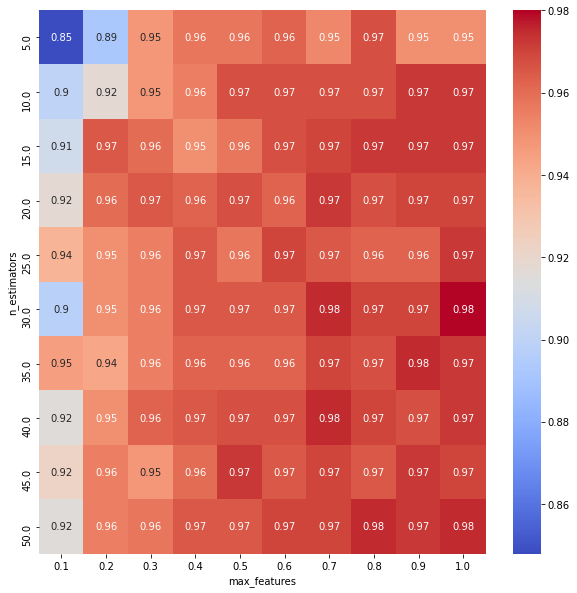

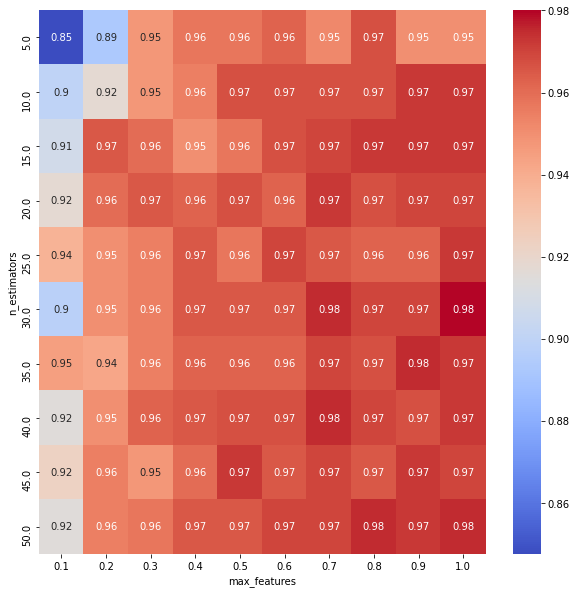

In [64]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

## Random Patches
Jest to połączenie klasycznego Baggingu i RandomSubspace.

Każdy z klasyfikatorów jest trenowany na podzbiorze danych oraz podzbiorze cech.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html


In [65]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9625935162094763

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 w zależności od wielkości podzbioru danych i cech.

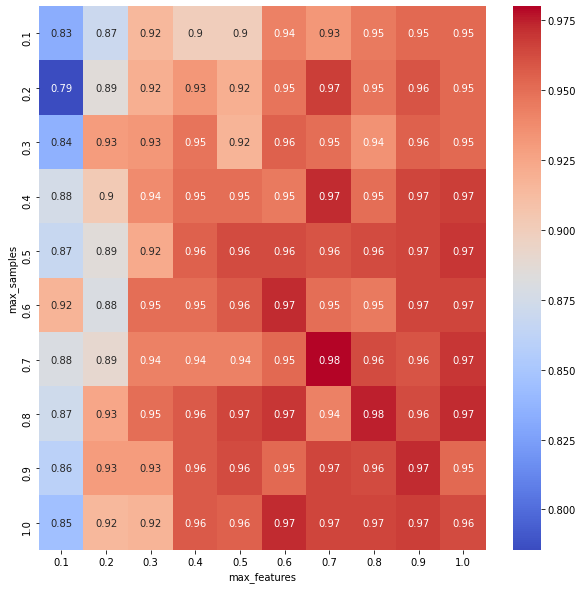

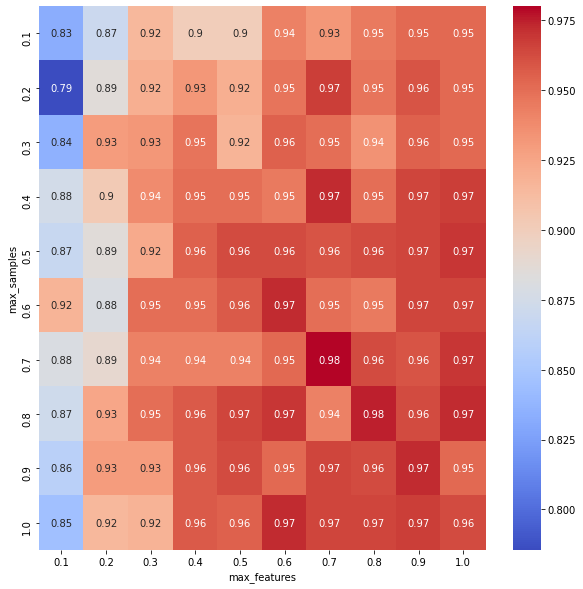

In [66]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

### ZADANIE:

Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji. Porównać wynik otrzymany dla random patches z wynikami dla VotingClassifier(z opcją voting='hard' oraz voting='soft')

## AdaBoost
Jest to metoda, która dla nowo tworzonych kopi klasyfikatorów uwzględnia dodatkowo wagi nieprawidłowo sklasyfikowanych instancji, tak aby mogły się one skoncentrować na bardziej skomplikowanych przypadkach.  
Domyślnie jako klasyfikator bazowy używany jest DecisionTreeClassifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [68]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8827930174563591

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla AdaBoost.

In [67]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.882793,0.882809
1,10.0,0.922693,0.922650
2,15.0,0.932668,0.932662
3,20.0,0.930175,0.930162
4,25.0,0.950125,0.950089
5,30.0,0.952618,0.952614
6,35.0,0.950125,0.950089
7,40.0,0.952618,0.952592
8,45.0,0.947631,0.947602
9,50.0,0.957606,0.957569


In [69]:
result.score.max(), result.score.idxmax()

(0.9775561097256857, 15)

In [70]:
result.score_f1.max(), result.score_f1.idxmax()

(0.9775541532830854, 15)

## Random Forest
Jest to metoda oparta o las drzew uczących. Każde z nich uczone jest na losowo wybranym podzbiorze danych wraz z podzbiorem cech. Skutkuje to zmniejszoną korelacją pomiędzy poszczególnymi drzewami.  
Poniżej przedstawiono wynik klasyfikacji dla 5 klasyfikatorów oraz zbiorze cech równym połowie początkowego zbioru.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [71]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.940149625935162

Teraz obserwujemy zmianę dokładności klasyfikacji i F1 dla Random Forest.


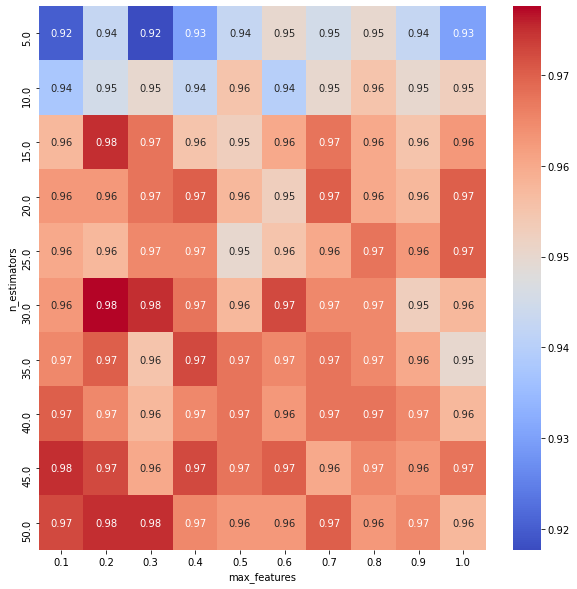

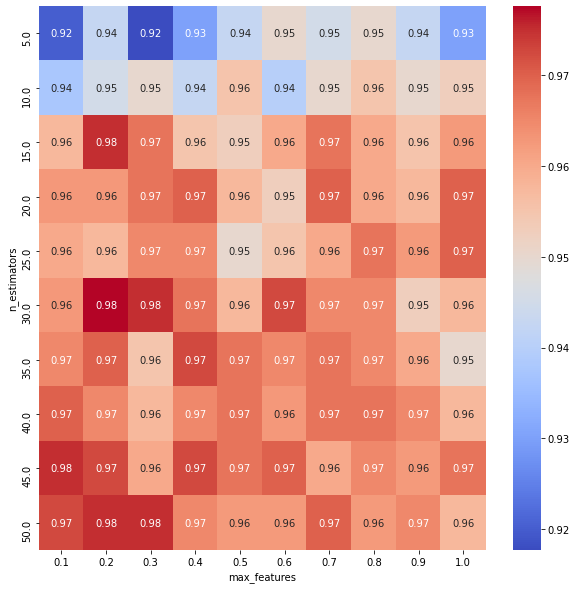

In [72]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

## Zadanie indywidualne

1. Przetransformować zbiór FMNIST używając PCA do przestrzeni 30D. Następnie wybrać 2 trudno rozdzielane klasy

In [96]:
fmnist = fetch_openml("Fashion-MNIST", data_home="data/fmnist", cache=True)
zipped_mnist = list(zip(mnist.data, mnist.target))
mnist_random = random.sample(zipped_mnist, 10000)
x, y = zip(*(mnist_random))
x = np.asarray(x)
y = np.asarray(y)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

pca = PCA(30)
x_pca = pca.fit_transform(x_scaled)

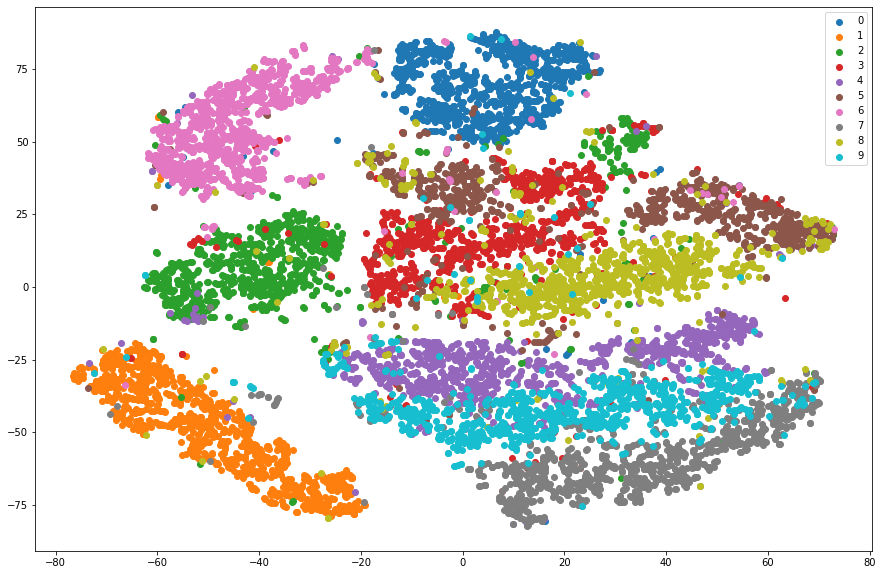

In [98]:
x_embedded = TSNE(n_components=2).fit_transform(x_pca)
plt.figure(figsize=(15,10))

for c, ids in zip(mcolors.TABLEAU_COLORS, [str(i) for i in range(10)]):
    plt.scatter(x_embedded[y == ids, 0], x_embedded[y == ids, 1], c=c, label=ids)
plt.legend()
plt.show()

In [117]:
digit_filter = np.where((y == '9') | (y == '7'))
x_filtered, y_filtered = x_pca[digit_filter], y[digit_filter]

In [118]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, train_size=0.8)
x_train.shape

(1620, 30)

2. Sprawdzić jak działa klasyczny Bagging dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru danych, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [119]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, max_samples=0.4, bootstrap=True) 
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9408866995073891

In [120]:
estimators = range(5, 51, 5)
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap": True} # bootstrap = True zapewnia losowość podzbiorów danych
result = ensemble(BaggingClassifier, estimators=estimators, samples=samples, params=params)
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.921182,0.921182
1,5.0,0.9,0.2,0.930883,0.931034
2,5.0,0.9,0.3,0.945797,0.945813
3,5.0,0.9,0.4,0.955652,0.955665
4,5.0,0.9,0.5,0.948245,0.948276
...,...,...,...,...,...
95,50.0,0.9,0.6,0.948245,0.948276
96,50.0,0.9,0.7,0.955643,0.955665
97,50.0,0.9,0.8,0.953174,0.953202
98,50.0,0.9,0.9,0.960580,0.960591


In [132]:
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.9,0.1,0.921182,0.921182
1,5.0,0.9,0.2,0.930883,0.931034
2,5.0,0.9,0.3,0.945797,0.945813
3,5.0,0.9,0.4,0.955652,0.955665
4,5.0,0.9,0.5,0.948245,0.948276
...,...,...,...,...,...
95,50.0,0.9,0.6,0.948245,0.948276
96,50.0,0.9,0.7,0.955643,0.955665
97,50.0,0.9,0.8,0.953174,0.953202
98,50.0,0.9,0.9,0.960580,0.960591


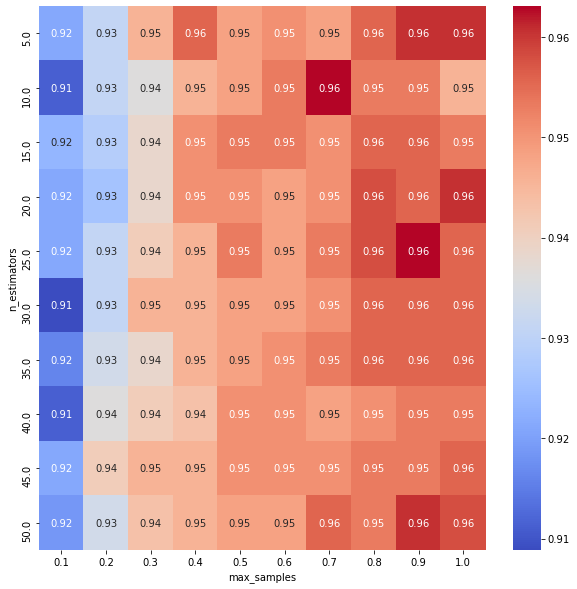

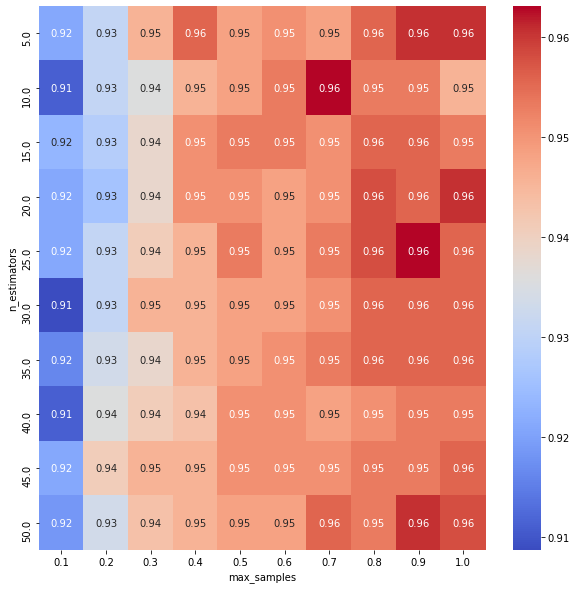

In [134]:

draw_heatmap('n_estimators', 'max_samples', result)

# F1
draw_heatmap('n_estimators', 'max_samples', result, score='score_f1')
# print("x")n_estimators', 'max_features', result, score='score_f1')

3. Sprawdzić jak działa RandomSubspace dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [103]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, bootstrap_features=True, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9433497536945813

In [104]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True} # zapewnia losowość pozdbioru cech

result = ensemble(BaggingClassifier, estimators=estimators, features=features, params=params)

In [105]:
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.1,0.9,0.864271,0.864532
1,5.0,0.2,0.9,0.891589,0.891626
2,5.0,0.3,0.9,0.938463,0.938424
3,5.0,0.4,0.9,0.943358,0.943350
4,5.0,0.5,0.9,0.938365,0.938424
...,...,...,...,...,...
95,50.0,0.6,0.9,0.950753,0.950739
96,50.0,0.7,0.9,0.950722,0.950739
97,50.0,0.8,0.9,0.950722,0.950739
98,50.0,0.9,0.9,0.948267,0.948276


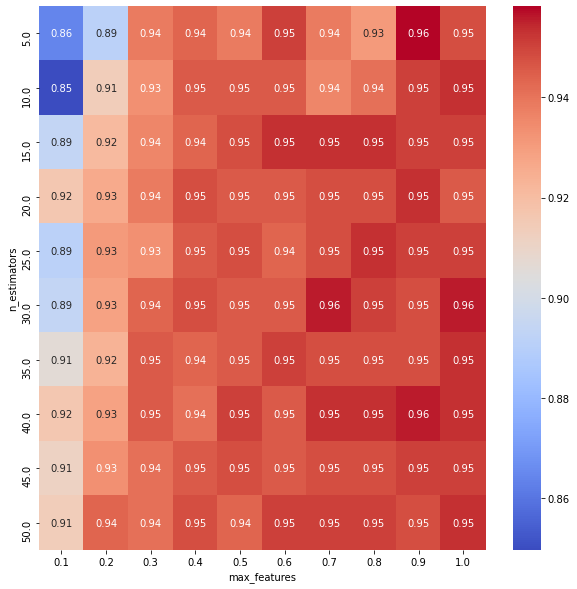

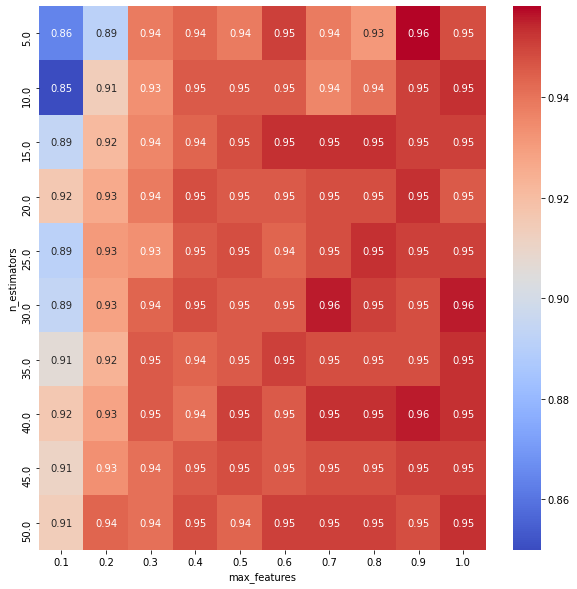

In [106]:
draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')

4. Sprawdzić jak działa RandomPatches dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej wielkości pozdzbioru danych i wielkości podzbioru cech, na których są uczone klasyfikatory  
    b) jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji.

In [107]:
classifier = BaggingClassifier(base_estimator=SVC(), n_estimators=5, 
                               bootstrap_features=True, max_features=0.5, max_samples=0.4)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.916256157635468

In [108]:
samples = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

params = {"base_estimator": SVC(), "bootstrap_features": True, "bootstrap": True }

result = ensemble(BaggingClassifier, features=features, samples=samples, params=params)

In [109]:
result

,n_estimators,max_features,max_samples,score_f1,score
0,5.0,0.1,0.1,0.856828,0.857143
1,5.0,0.2,0.1,0.903890,0.903941
2,5.0,0.3,0.1,0.906404,0.906404
3,5.0,0.4,0.1,0.923722,0.923645
4,5.0,0.5,0.1,0.881733,0.881773
...,...,...,...,...,...
95,5.0,0.6,1.0,0.938433,0.938424
96,5.0,0.7,1.0,0.950765,0.950739
97,5.0,0.8,1.0,0.960603,0.960591
98,5.0,0.9,1.0,0.948284,0.948276


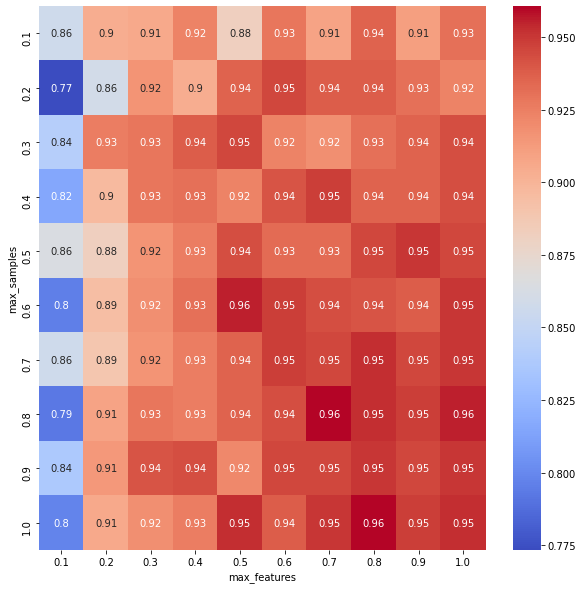

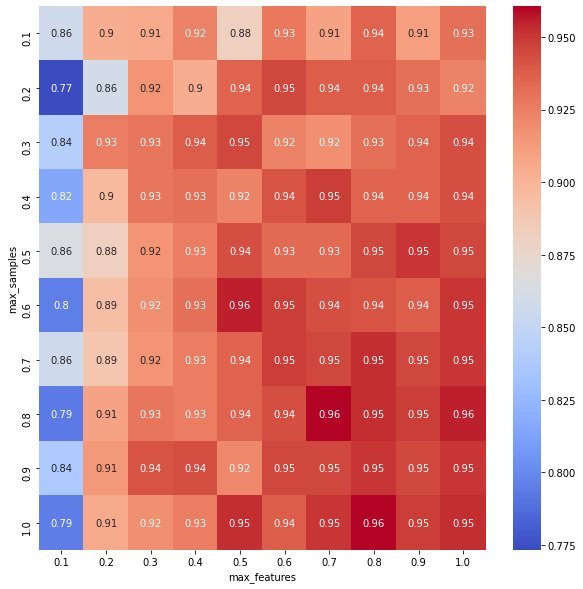

In [110]:
draw_heatmap('max_samples', 'max_features', result)

draw_heatmap('max_samples', 'max_features', result, score='score_f1')

5. Sprawdzić jak działa AdaBoost dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów

In [111]:
classifier = AdaBoostClassifier(n_estimators=5, random_state=7)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.8694581280788177

In [112]:
estimators = range(5, 101, 5)

result = pd.DataFrame(columns=['n_estimators', 'score', 'score_f1'])
for n_estimators in estimators:
    clf = AdaBoostClassifier(n_estimators=n_estimators, random_state=7)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    row = { 'n_estimators':n_estimators,
            'score': clf.score(x_test, y_test),
            'score_f1': f1_score(y_test, pred, average='weighted')
          }
    result = result.append(row, ignore_index=True)
result

,n_estimators,score,score_f1
0,5.0,0.869458,0.869563
1,10.0,0.901478,0.901550
2,15.0,0.899015,0.899030
3,20.0,0.928571,0.928560
4,25.0,0.921182,0.921205
5,30.0,0.933498,0.933508
6,35.0,0.935961,0.935995
7,40.0,0.945813,0.945842
8,45.0,0.943350,0.943386
9,50.0,0.948276,0.948298


In [113]:
result.score.max(), result.score.idxmax()

(0.9532019704433498, 14)

In [114]:
result.score_f1.max(), result.score_f1.idxmax()

(0.953231860604872, 14)

6. Sprawdzić jak działa RandomForest dla 5 klasyfikatorów prostych. Następnie określić:  
    a) jak zmienia się dokładność klasyfikacji oraz F1 score dla wzrastającej liczby klasyfikatorów i wielkości podzbioru cech, na których są uczone klasyfikatory

In [115]:
classifier = RandomForestClassifier(n_estimators=5, max_features=0.5)
classifier.fit(x_train, y_train)
classifier.score(x_test, y_test)

0.9261083743842364

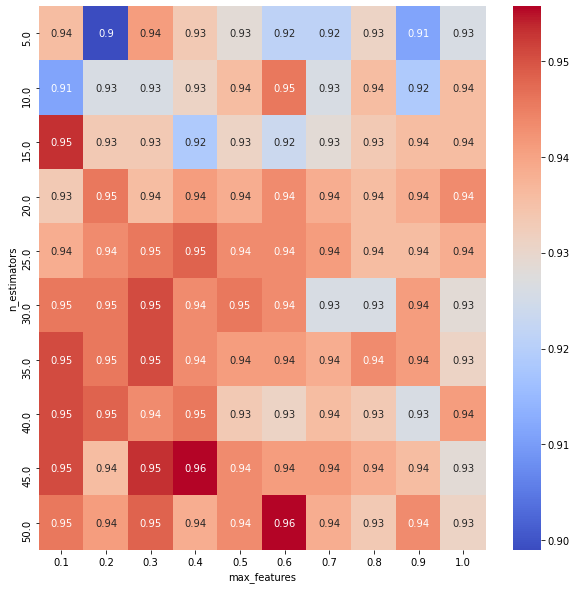

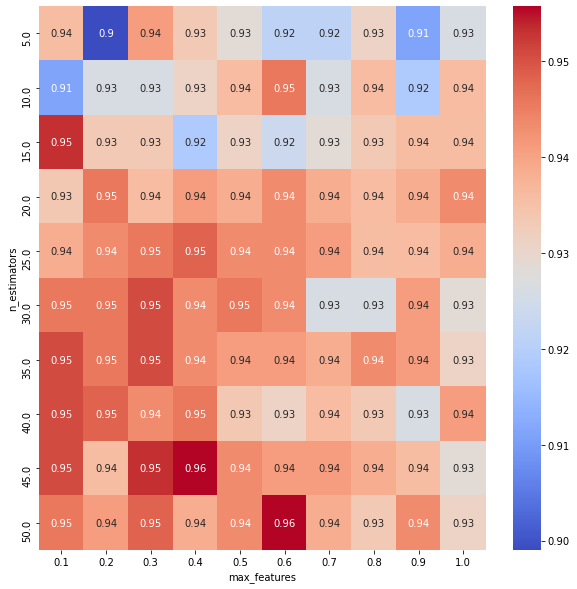

In [116]:
estimators = range(5, 51, 5)
features = list(map(lambda x: round(x, 1), np.arange(0.1, 1.1, 0.1)))

result = ensemble(RandomForestClassifier, estimators=estimators, features=features)

draw_heatmap('n_estimators', 'max_features', result)

draw_heatmap('n_estimators', 'max_features', result, score='score_f1')